주어진 데이터셋을 차원 축소한 뒤 **다양한 알고리즘**을 적용하여 클러스터링을 진행하고, 결과를 시각화하는 작업을 직접 해보면서 **비지도학습** (Unsupervised Learning)에 대한 이해도를 높여 봅시다.

In [1]:
## 필요한 라이브러리를 임포트합니다.

import pandas as pd
import numpy as np

In [2]:
## 시각화 관련 라이브러리를 임포트합니다.

from matplotlib import pyplot as plt
import seaborn as sns

###데이터

사용할 데이터: 'Marketing Campaign.csv'

주어진 데이터는 마케팅 캠페인을 펼치고자 하는 소비자들에 대한 정보를 나타낸 데이터입니다. 해당 소비자들을 알맞게 군집화시키는 것이 우리의 목적입니다.

총 29개의 column으로 구성되어 있습니다. 



---







데이터에 대한 자세한 설명은 해당 kaggle 페이지에서 확인하실 수 있습니다.

https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign

데이터를 불러옵니다.

In [3]:
## drive에 있는 데이터셋을 불러오기 위해 드라이브와 연동을 합니다.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cd '/content/drive/MyDrive/DSL/23-1 정규세션/[0209] Clustering'

/content/drive/MyDrive/DSL/23-1 정규세션/[0209] Clustering


In [6]:
## 'Marketing_campaign' 데이터의 위치를 불러와 저장합니다.

data = pd.read_csv('./marketing_campaign.csv', \
                   sep = ';')
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [7]:
data.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

### 데이터 전처리

In [8]:
## 등록한 이후에 현재까지의 기간(회원 일수)를 'days'라는 변수로 저장.
from datetime import datetime

y = datetime.today() #datetime 타입으로 변환

data.Dt_Customer = pd.to_datetime(data.Dt_Customer, format='%Y-%m-%d') #datetime 타입으로 변환
data['days'] = y - data.Dt_Customer
data['days'] = data['days'] / np.timedelta64(1, 'D')
data['days'] = data['days'].astype('int')
data['days'][:5]

0    3814
1    3264
2    3463
3    3290
4    3312
Name: days, dtype: int64

In [9]:
## 나이를 age에 저장
data['age'] = 2024-data['Year_Birth']

In [10]:
## 마케팅 캠페인에서의 총 참여 횟수
data['CampaignAttendance'] = data.iloc[:,20:25].sum(axis=1)

## 이 데이터랑 군집화 결과가 얼마나 유사하게, 또는 다르게 나오는지 비교해봅시다~!!

In [11]:
data.columns

features = ['days', 'age', 'Income', 'Recency', 'MntWines', 'MntFruits',\
                     'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',\
                     'MntGoldProds', 'NumDealsPurchases','NumWebPurchases', \
                     'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',\
                    'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',\
                    'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response','CampaignAttendance'] #우리가 고려할 변수들

In [12]:
X_features = data[features]
X_features = X_features.dropna().reset_index(drop = True) #결측치 제거

y_label = X_features['CampaignAttendance'] #캠페인에서의 총 참여 횟수를 임의의 라벨값으로 설정 -> 기준으로 삼아보자.

X_features = X_features.drop(['CampaignAttendance'], axis = 1)

In [13]:
## 각 변수들을 '표준화' scaling 합니다.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_features_scaling  = scaler.fit_transform(X_features)

X_features_scaling = pd.DataFrame(X_features_scaling, columns = X_features.columns, index = list(X_features.index.values))

###차원 축소

데이터를 차원 축소 해봅시다.

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## LDA
lda = LinearDiscriminantAnalysis(n_components = 2)
X_train_lda = lda.fit_transform(X_features_scaling, y_label) #차원축소 과정에 y 라벨값을 입력해줌

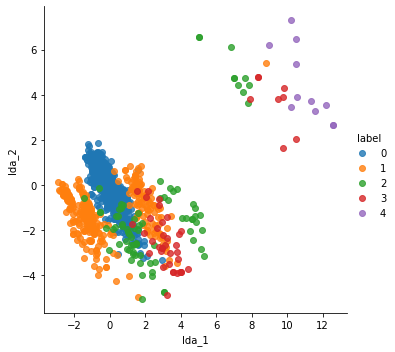

In [15]:
X_train_lda = pd.DataFrame(X_train_lda).loc[:,0:1]
X_train_lda = pd.concat((X_train_lda, y_label), axis = 1) #X_train_Ida와 y_label 데이터를 하나로 합치기
X_train_lda.columns = ['lda_1', 'lda_2', 'label']
X_train_lda

sns.lmplot(x = 'lda_1',y = 'lda_2',data = X_train_lda, hue = 'label', fit_reg = False)
plt.show()

## 우리가 원하는 정답 모양
## 캠페인 참여에서의 총 참여 횟수를 라벨값으로 둔 상태에서의 데이터 분포도

###K-means Clustering

클러스터링을 돌려 보는 데에 의의가 있기에, 파라미터 값 최적화보다는 각 알고리즘을 사용하면 결과가 어떻게 달라지는 지에 초점을 맞추어 살펴봅니다. 여러 번 시행해보면서 **자유롭게 파라미터를 정해주세요**.

**(직접 최적의 파라미터 값을 찾아서 설정하고 싶으시다면 훨씬 좋습니다! 해당 과제의 모든 코드는 기본 뼈대일 뿐입니다. 코드를 추가 또는 변경하셔도 좋습니다.)**

다른 x값들에 대해서도 캠페인 참여도, 즉 고객의 충실도를 잘 군집화할 수 있을까요? 클러스터링으로 결과를 확인해봅시다.



---





K-means를 이용하여 클러스터링 해봅시다.

In [16]:
## 필요한 라이브러리를 임포트합니다.

from sklearn.cluster import KMeans

In [84]:
## 클러스터 수는 ########(숫자)########로 설정하고, KMeans를 활용하여 예측된 y값을 만들어 봅시다.

km = KMeans(n_clusters = 6)

y_km = km.fit_predict(X_features_scaling)
y_km

array([0, 1, 2, ..., 4, 2, 1], dtype=int32)

In [85]:
X_train_lda['K_means'] = y_km

####시각화

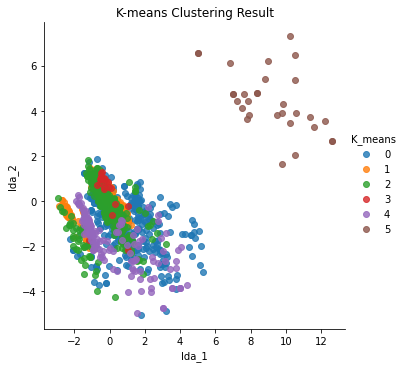

In [86]:
sns.lmplot(x = 'lda_1', y = 'lda_2', data = X_train_lda, hue = 'K_means', fit_reg = False)
plt.title('K-means Clustering Result')
plt.show()

###Hierarchical Clustering

Agglomerative 방법을 이용하여 클러스터링 해봅시다.

In [32]:
## 필요한 라이브러리를 임포트합니다.

from sklearn.cluster import AgglomerativeClustering

In [36]:
## 클러스터 수는 ########(숫자)########로 설정하고, Agglomerative를 활용하여 예측된 y값을 만들어 봅시다.

agghc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward') #와드연결법을 사용합니다.

y_agghc = agghc.fit_predict(X_features_scaling)
y_agghc

array([2, 0, 2, ..., 0, 2, 0])

In [37]:
X_train_lda['hierarchical'] = y_agghc

####시각화

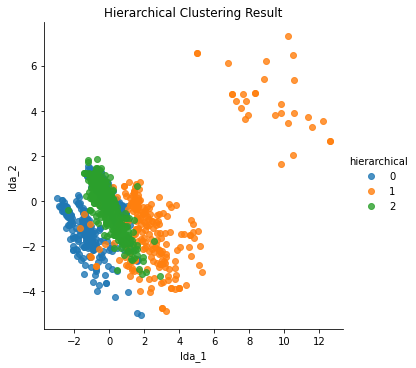

In [38]:
sns.lmplot(x = 'lda_1', y = 'lda_2', data = X_train_lda, hue = 'hierarchical', fit_reg = False)
plt.title('Hierarchical Clustering Result')
plt.show()

###DBSCAN

DBSCAN을 이용하여 클러스터링 해봅시다.

In [39]:
## 필요한 라이브러리를 임포트합니다.

from sklearn.cluster import DBSCAN

In [77]:
## eps는 ########(숫자)########, minPts는 ########(숫자)########로 설정한 뒤 DBSCAN를 활용하여 예측된 y값을 만들어 봅시다.

dbscan = DBSCAN(eps = 0.6, min_samples = 3, metric = 'euclidean') #eps는 0-1

y_dbscan = dbscan.fit_predict(X_features_scaling)
y_dbscan

array([-1, -1, -1, ..., -1, -1, -1])

In [78]:
X_train_lda['dbscan'] = y_dbscan

####시각화

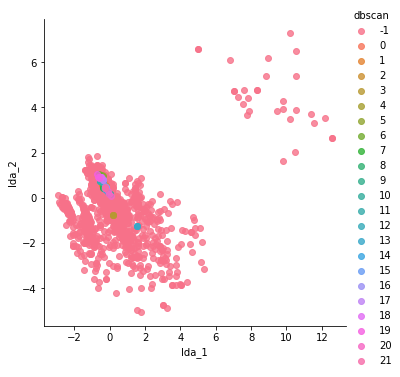

In [79]:
sns.lmplot(x = 'lda_1', y = 'lda_2', data = X_train_lda, hue = 'dbscan', fit_reg = False)
plt.show()

###Validation

실루엣 계수를 사용하여 각 클러스터링의 성능을 평가해봅시다.



---



(Q) 실루엣 계수로 평가하기 전에, 육안 상으로 어떠한 알고리즘의 성능이 제일 높아 보이며 어떠한 알고리즘의 성능이 제일 낮아 보이는지 의견을 적어주세요.

육안 상으로는 Agglomerative 클러스터링 알고리즘의 성능이 제일 높아보이는 반면에 DBSCAN의 성능이 가장 낮아보인다.



---



이제 실루엣 계수로 성능을 평가해 봅시다!

In [70]:
## 필요한 라이브러리를 임포트합니다.

import sklearn.metrics as metrics
from sklearn.metrics.cluster import silhouette_score

K-means Clustering의 실루엣 계수입니다.

In [87]:
coef_km = metrics.silhouette_score(X_features_scaling, y_km)
print('Silhouette score is {}.'.format(coef_km))

Silhouette score is 0.1986658433467094.


Hierarchical Clustering의 실루엣 계수입니다.

In [72]:
## Hierarchical Clustering

coef_hc = metrics.silhouette_score(X_features_scaling, y_agghc)
print('Silhouette score is {}.'.format(coef_hc))

Silhouette score is 0.21288254462011363.


DBSCAN의 실루엣 계수입니다.

In [73]:
## DBSCAN

coef_db = metrics.silhouette_score(X_features_scaling, y_dbscan)
print('Silhouette score is {}.'.format(coef_db))

Silhouette score is -0.400665940431348.


(Q) 실루엣 계수를 기반으로, 클러스터링 알고리즘의 성능을 높은 순대로 적어주세요.

Hierarchical 클러스터링 -> K-means 클러스터링 -> DBSCAN 순으로 성능이 높다.

(Q) 클러스터링 결과에 대한 해석을 적어주세요. (참고로, 실루엣 계수는 -1에서 1 사이의 값을 가집니다.)

주어진 데이터에서 DBSCAN 기반의 클러스터링은 부적절한 것 같다. Hierarchical 클러스터링의 결과가 가장 좋았지만 K-means와 비교해보았을 때 월등히 나은 것은 아니다.

(Q) 마케팅 캠페인과 관련하여 도출할 수 있는 인사이트를 적어주세요.

소비자를 3개의 군집으로 나누어서 각 군집을 타겟할 수 있는 구체적인 마케팅 방안을 이용하면 좋을 것 같다.